In [2]:
# Install and import TF2
!pip install -q tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
     |████████████████████████████████| 450kB 45.9MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
2.0.0


In [3]:
# By the way, what is a server/service/API?

# We hit a service that reurns our IP in a JSON
import requests
r = requests.get('https://api.ipify.org?format=json')
j = r.json()
print(j)

# Our Tensorflow model server is the same, except that what it does is much more
# complex - it returns the predictions from a ML model:

{'ip': '35.187.58.2'}


In [0]:
# More imports
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model


In [5]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)


In [6]:
# the data is only 2D!
# convolution expects height x width x color
x_train = np.expand_dims(x_train,-1)
x_test = np.expand_dims(x_test,-1)
print(x_train.shape)

(60000, 28, 28, 1)


In [7]:
# number of classes
K = len(set(y_train))
print("number of classes", K)

number of classes 10


In [8]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3,3), strides=2, activation='relu')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [9]:
# Compile and fit
# Note: make sure you are using the GPU for this
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 34s 562us/sample - loss: 0.5239 - accuracy: 0.8054 - val_loss: 0.3877 - val_accuracy: 0.8551
Epoch 2/15
60000/60000 [==============================] - 32s 538us/sample - loss: 0.3644 - accuracy: 0.8631 - val_loss: 0.3461 - val_accuracy: 0.8735
Epoch 3/15
60000/60000 [==============================] - 32s 536us/sample - loss: 0.3149 - accuracy: 0.8820 - val_loss: 0.3253 - val_accuracy: 0.8805
Epoch 4/15
60000/60000 [==============================] - 32s 536us/sample - loss: 0.2830 - accuracy: 0.8931 - val_loss: 0.3090 - val_accuracy: 0.8874
Epoch 5/15
60000/60000 [==============================] - 32s 531us/sample - loss: 0.2568 - accuracy: 0.9018 - val_loss: 0.3141 - val_accuracy: 0.8848
Epoch 6/15
60000/60000 [==============================] - 32s 528us/sample - loss: 0.2336 - accuracy: 0.9111 - val_loss: 0.3088 - val_accuracy: 0.8912
Epoch 7/15
60000/60000 [====================

In [11]:
# Save the model to a temporary directory
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path= {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model: cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path= /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 168
drwxr-xr-x 2 root root   4096 Jan 10 22:59 assets
-rw-r--r-- 1 root root 162074 Jan 10 22:59 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 10 22:59 variables


In [12]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [13]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18626      0 --:--:-- --:--:-- --:--:-- 18626
OK
Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 htt

In [14]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 140 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.0.0 [140 MB]
Fetched 140 MB in 2s (63.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.0.0_all.deb ...
Unpacking tensorflow-model-server (2.0.0) ...
Setting up tensorflow-model-server (2.0.0) ...


In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [16]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [17]:
!tail server.log

2020-01-10 23:19:23.301484: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-10 23:19:23.317634: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2020-01-10 23:19:23.361710: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /tmp/1
2020-01-10 23:19:23.369796: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 72775 microseconds.
2020-01-10 23:19:23.370611: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-01-10 23:19:23.370709: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-01-10 23:19:23.372123: 

In [0]:
# Label mapping
labels = '''Tshirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

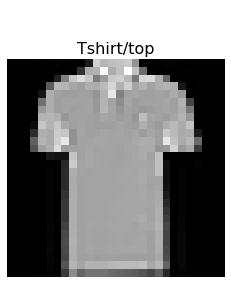

In [23]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28),cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title),fontdict={'size': 16})

i = np.random.randint(0,len(x_test))
show(i, labels[y_test[i]])


In [30]:
# Format some data to pass to the server
# {
#   "signature_name": "service_defaut",
#   "instances": [an N x H x W x C list ],   
# }
import json
data = json.dumps({ "signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [31]:
headers = {"content-type": "application/json"}
r = requests.post("http://localhost:8501/v1/models/fashion_model:predict", data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

dict_keys(['predictions'])
{'predictions': [[3.32369427e-14, 1.24373156e-16, 4.42159807e-12, 2.33851884e-15, 1.11807026e-12, 9.99885685e-08, 2.96737393e-14, 1.40697654e-09, 6.01569304e-13, 0.999999881], [0.000131722714, 6.43381451e-15, 0.999861836, 1.55695012e-08, 3.99148831e-07, 1.55135846e-13, 6.05647165e-06, 3.13368944e-15, 4.79448356e-11, 5.79155135e-15], [1.86419847e-34, 1.0, 0.0, 0.0, 3.37902189e-38, 0.0, 0.0, 0.0, 3.68312778e-34, 0.0]]}


In [35]:
# it looks like a 2D array, lets check its shape
pred = np.array(j['predictions'])
print(pred.shape)

# this is the NxK output array from themodel
# pred[n,k] is the probability that we beleieve the nth sample belongs to the kth class

(3, 10)


In [36]:
# get the predicted classes
pred = pred.argmax(axis=1)
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

['Ankle boot', 'Pullover', 'Trouser']


In [37]:
# Get the true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

['Ankle boot', 'Pullover', 'Trouser']


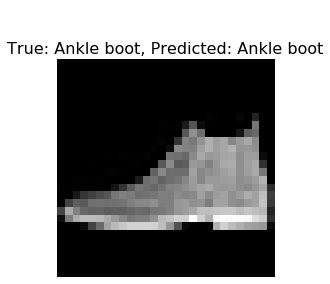

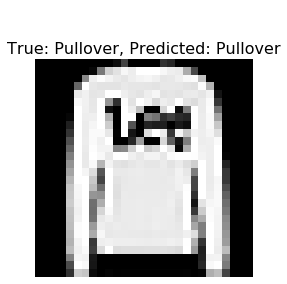

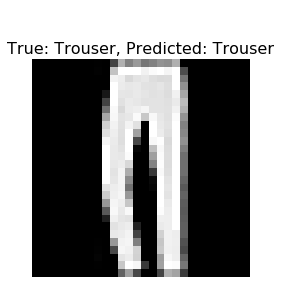

In [38]:
for i in range(0,3):
  show(i,f'True: {actual[i]}, Predicted: {pred[i]}')

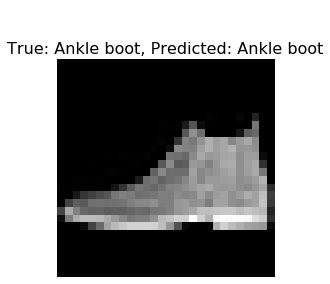

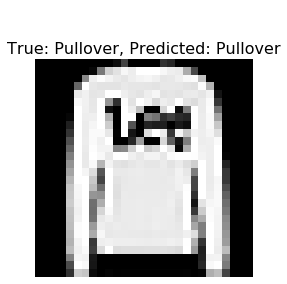

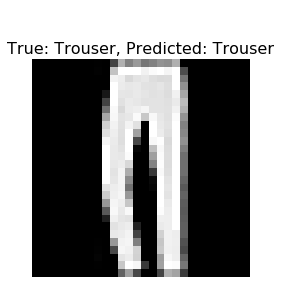

In [39]:
# Allows you to select a model by version

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [40]:
# Let's make a new model version
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)

model2 = Model(i, x)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Compile and fit
# Note: make sure you are using the GPU for this!
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 13s 222us/sample - loss: 0.4577 - accuracy: 0.8390 - val_loss: 0.3791 - val_accuracy: 0.8586
Epoch 2/15
60000/60000 [==============================] - 13s 214us/sample - loss: 0.3198 - accuracy: 0.8864 - val_loss: 0.3437 - val_accuracy: 0.8772
Epoch 3/15
60000/60000 [==============================] - 13s 212us/sample - loss: 0.2873 - accuracy: 0.8975 - val_loss: 0.3172 - val_accuracy: 0.8862
Epoch 4/15
60000/60000 [==============================] - 13s 213us/sample - loss: 0.2663 - accuracy: 0.9037 - val_loss: 0.3081 - val_accuracy: 0.8887
Epoch 5/15
60000/60000 [==============================] - 13s 211us/sample - loss: 0.2509 - accuracy: 0.9095 - val_loss: 0.3052 - val_accuracy: 0.8918
Epoch 6/15
60000/60000 [==============================] - 11s 191us/sample - loss: 0.2371 - accuracy: 0.9155 - val_loss: 0.2939 - val_accuracy: 0.8946
Epoch 7/15
60000/60000 [====================

In [42]:
# Save version 2 of the model

version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model2, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/2

INFO:tensorflow:Assets written to: /tmp/2/assets

Saved model:
total 84
drwxr-xr-x 2 root root  4096 Jan 11 00:17 assets
-rw-r--r-- 1 root root 74373 Jan 11 00:17 saved_model.pb
drwxr-xr-x 2 root root  4096 Jan 11 00:17 variables


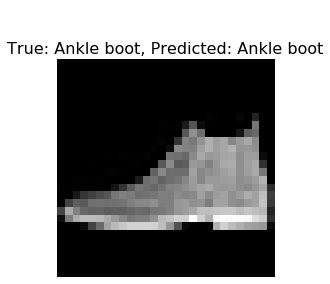

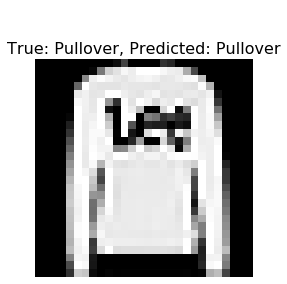

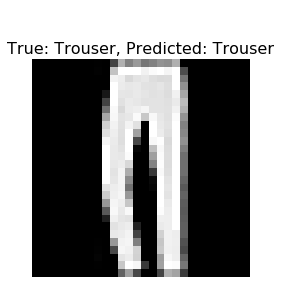

In [43]:
# Will Tensorflow serving know about the new model without restarting?

headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/2:predict', data=data, headers=headers)
j = r.json()
pred = np.array(j['predictions'])
pred = pred.argmax(axis=1)
pred = [labels[i] for i in pred]
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")

In [44]:
# What if we use a version number that does not exist?
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model/versions/3:predict', data=data, headers=headers)
j = r.json()
print(j)

{'error': 'Servable not found for request: Specific(fashion_model, 3)'}
